In [118]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import warnings
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,precision_score,recall_score,f1_score
sys.path.append('../')
pd.options.mode.chained_assignment = None 



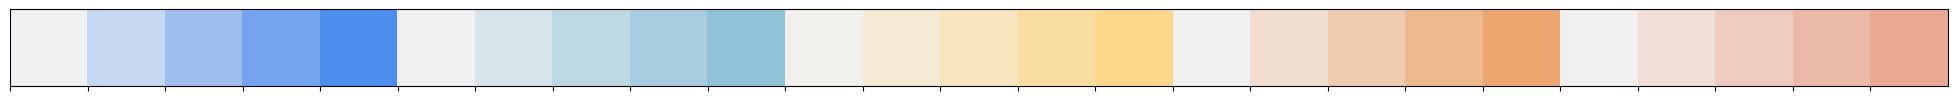

In [119]:
colors =['#4C8CED','#90C2D8','#FCD88D','#ECA771','#EBA991']
full_palette = sns.color_palette(colors)
sns.set_palette(full_palette)
cmap = LinearSegmentedColormap.from_list("custom_cmap", full_palette)
third_class = 'unknown'
expanded_palette = []

for color in colors:
    shades = sns.light_palette(color, n_colors=5)
    expanded_palette.extend(shades)

expanded_palette
sns.palplot(expanded_palette)

In [120]:
palette = {
    "THRS_BIDIRECTIONAL":    expanded_palette[4],
    "THRS_DOUBLE": expanded_palette[3],
    "THRS_SINGLE":expanded_palette[2],
    "BEE_ANGLE_BIDIRECTIONAL": expanded_palette[9],
    "BEE_ANGLE_SUM":expanded_palette[8],
    "BEE_ANGLE_START":expanded_palette[7],
    "BEE_ANGLE_END":expanded_palette[6],
    "DISP_BIDIRECTIONAL":expanded_palette[24],
    "DISP_START_END":expanded_palette[23],
    "DISP_START":expanded_palette[22],
    "DISP_END":expanded_palette[21]
}

In [121]:
vdf = pd.read_csv("beeActivity.csv")
#vdf = vdf.drop_duplicates(subset=['track_starttime','track_tagid'], keep='last')

In [122]:
#DISTANCE THRESHOLD
#used to classify an event as entering or exiting
#when two consecutive detections of the same event 
#have this distance in y position, they are utilized to predict
#the trajectory. If not then it checks the detection prior for
#the distance threshold, and continues doing so until it finds
#the last detection in the event or until it finds a distance
#of more than the threshold

t2 = 100

#ANGLE THRESHOLD
#used to generate angle ranges for classifying as exiting
#or entering

angle = 10

def classify_algo(algorithm):
    if 'THRS' in algorithm:
        return 'Threshold'
    elif 'ANGLE' in algorithm:
        return 'Angle'
    else:
        return 'Displacement'

def classify_hatch(algorithm):
    if 'START_END' in algorithm:
        return 'Start_End'
    elif 'START' in algorithm:
        return 'Start'
    elif 'END' in algorithm:
        return 'End'
    elif 'BIDIRECTIONAL' in algorithm:
        return 'Bi'
    else:
        return 'Other'

hatch_map = {'Start_End':'|','Start':'\\','End':'/','Bi':'-','Other':'.'}


## APPROACHES

In [123]:
#APPROACHES 1 - INSIDE-OUTSIDE OR OUTSIDE-INSIDE

#two thresholds
def in_out(data):
    exiting = ['inside_outside','ramp_outside']
    entering = ['outside_inside','outside_ramp']
    if data['track_shape'].iloc[-1] in exiting:
        return "exiting"
    elif data['track_shape'].iloc[-1] in entering:
        return "entering"
    else:
        return "unknown"

#single threshold
def in_out_single(data):
    if data['track_starty'].iloc[-1] < 770:
        str1 = 'outside'
    else:
        str1 = 'inside'

    if data['track_endy'].iloc[-1] < 770:
        str2 = "outside"
    else:
        str2 = "inside"
    track_shape = f'{str1}_{str2}'
    exiting = ['inside_outside']
    entering = ['outside_inside']
    if track_shape in exiting:
        return "exiting"
    elif track_shape in entering:
        return "entering"
    else:
        return "unknown"

#APPROACHES 2 ITERATE BACKWARDS DISPLACEMENT
def displacement(data):            
        coordinates = data['cy']

        #assign final position to final variable
        final = coordinates.iloc[-1]

        #iterate backwards until distance threshold is surpassed
        for k in range(len(coordinates)):
            prev = coordinates.iloc[len(coordinates)-k-1]
            dif = final - prev
            if abs(dif) >= t2:
                if dif < 0:
                    return 'exiting'
                elif dif > 0:
                    return 'entering'
                else:
                    return 'unknown'
                break
            #if distance is never surpassed, reach the very first index
            elif k == len(coordinates) - 1:
                if dif < 0:
                    return 'exiting'
                elif dif > 0:
                    return 'entering'
                else:
                    return 'unknown'
            

#APPROACHES 3 SUMMED DIRECTIONAL ANGLE

def angles(data):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    #obtain all angles of event
    coordinates = data['angle'].to_numpy()

    #obtain vector angle
    unit_dx = np.cos(np.deg2rad(coordinates))
    unit_dy = np.sin(np.deg2rad(coordinates))
    avg_x = np.average(unit_dx)
    avg_y = np.average(unit_dy)
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#subfunction of previous application, except with one
#single angle instead

def getangle(coordinates):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    avg_x = np.cos(np.deg2rad(coordinates))
    avg_y = np.sin(np.deg2rad(coordinates))
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#APPROACHES 4 LAST DIRECTIONAL ANGLE

def lastangle(data):
   
    coordinates = data['angle'].iloc[-1]

    return getangle(coordinates)


#APPROACHES 5 INIT - FINAL DISPLACEMENT
def displacementinit(data):            
        coordinates = data['cy']
        
        final = coordinates.iloc[-1]
        init = coordinates.iloc[0]

        if init > final:
            return 'exiting'
        elif final > init:
            return 'entering'
        else:
            return 'unknown'             

#APPROACHES 6 FIRST DIRECTIONAL ANGLE

def firstangle(data):
   
    coordinates = data['angle'].iloc[0]

    return getangle(coordinates)


#APPROACHES 7 ITERATE FORWARDS DISPLACEMENT
def displacement2(data):            
        coordinates = data['cy']

        #set first variable to first position in event
        first = coordinates.iloc[0]

        #iterate forward until distance threshold is surpassed
        for k in range(1,len(coordinates)):
            next = coordinates.iloc[k]
            dif = first - next
            if abs(dif) >= t2:
                if dif > 0:
                    return 'exiting'
                elif dif < 0:
                    return 'entering'
                else:
                    return 'unknown'
                break
            #if never surpassed, compare with very last detection
            elif k == len(coordinates) - 1:
                if dif > 0:
                    return 'exiting'
                elif dif < 0:
                    return 'entering'
                else:
                    return 'unknown'
            


####CLASSIFICATION AS ENTERING-EXITING OR EXITING-ENTERING

#APPROACHES 1 ITERATE BACKWARDS AND FORWARDS DISPLACEMENT
#COMBINES FORWARD ITERATION AND BACKWARDS ITERATION
def displacementbackforth(data):   

        coordinates = data['cy']

        #ending movement
        final = coordinates.iloc[-1]
        
        for k in range(len(coordinates)):
            prev = coordinates.iloc[len(coordinates)-k-1]
            dif = final - prev
            if abs(dif) >= t2:
                if dif < 0:
                    string2 = 'exiting'
                elif dif > 0:
                    string2 = 'entering'
                else:
                    string2 = 'unknown'
                break
            elif k == len(coordinates) - 1:
                if dif < 0:
                    string2 = 'exiting'
                elif dif > 0:
                    string2 = 'entering'
                else:
                    string2 = 'unknown'
        if len(coordinates) == 1:
            string2 = "unknown"
        #beginning movement
        #iterate forwards
        first = coordinates.iloc[0]
        
        for k in range(1,len(coordinates)):
            next = coordinates.iloc[k]
            dif = first - next
            if abs(dif) >= t2:
                if dif > 0:
                    string = 'exiting'
                elif dif < 0:
                    string = 'entering'
                else:
                    string = 'unknown'
                break
            elif k == len(coordinates) - 1:
                if dif > 0:
                    string = 'exiting'
                elif dif < 0:
                    string = 'entering'
                else:
                    string = 'unknown'

        if len(coordinates) == 1:
            string = "unknown"

        #if both directions are the same, return value
        #else return compound event
        return string if string == string2 else f"{string}-{string2}"
        

#APPROACHES 2 FIRST AND LAST DIRECTIONAL ANGLE
#COMBINES FIRST ANGLE AND LAST ANGLE

def lastfirstangle(data):

    coordinates = data['angle'].iloc[-1]

    string2 = getangle(coordinates)

    coordinates = data['angle'].iloc[0]

    string = getangle(coordinates)

    #if both directions are the same, return value
    #else return compound event
    return string if string == string2 else f"{string}-{string2}"


#APPROACHES 3 THRESHOLD BIDIRECTIONAL
def in_out2(data):
    if data['track_shape'].iloc[-1] == "inside_outside" or data['track_shape'].iloc[-1] == "ramp_outside":
        return "exiting"
    elif data['track_shape'].iloc[-1] == "outside_inside" or data['track_shape'].iloc[-1] == "outside_ramp":
        return "entering"
    elif data['track_shape'].iloc[-1] == "outside_outside":
        return "entering-exiting"
    elif data['track_shape'].iloc[-1] == "inside_inside":
        return "exiting-entering"
    else:
        return "unknown"
        

In [124]:
#read cheatsheet of all cases

cheatsheet = pd.read_csv("cheatsheet.csv")

## ACCURACY 

Recall tested on regular simple cases

In [125]:
#compare classifications against ground truth

removed = ['entering-exiting','exiting-entering','unknown']

cheatsheet1 = cheatsheet[~cheatsheet.event.isin(removed)]

entering_count = len(cheatsheet[cheatsheet['event'] == 'entering'])
exiting_count = len(cheatsheet[cheatsheet['event'] == 'exiting'])
individual_counts = {}

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_SUM': angles,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
}

for_matrix = {}

for APPROACHES, func in functions.items():
    individual_counts[APPROACHES] = {'entering':0,'exiting':0}

for APPROACHES, func in functions.items():
    for_matrix[APPROACHES] = []
    
accuracy = {r: 0 for r in functions}

for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]

    for APPROACHES, func in functions.items():
        result = func(detections)
        for_matrix[APPROACHES].append(result)
        if result == event:
            accuracy[APPROACHES] += 1
            individual_counts[APPROACHES][event] += 1
            
        

In [126]:
results = {k: v/len(cheatsheet1) for k, v in accuracy.items()}
results

{'THRS_DOUBLE': 0.9795918367346939,
 'THRS_SINGLE': 0.9795918367346939,
 'DISP_START_END': 0.9970845481049563,
 'DISP_START': 0.9825072886297376,
 'DISP_END': 0.9737609329446064,
 'BEE_ANGLE_SUM': 0.9766763848396501,
 'BEE_ANGLE_START': 0.8717201166180758,
 'BEE_ANGLE_END': 0.8513119533527697}

In [127]:
df_simple = pd.DataFrame.from_dict(individual_counts).transpose().reset_index()
df_simple['entering'] = df_simple['entering']/entering_count
df_simple['exiting'] = df_simple['exiting']/exiting_count
df_simple = pd.melt(df_simple, id_vars=['index'], value_vars=['entering','exiting'])
df_simple = df_simple.rename(columns={"index": "algorithm", "variable": "event", "value": "accuracy"})
df_simple['class'] = df_simple['algorithm'].apply(lambda x: classify_algo(x))
df_simple['hatch'] = df_simple['algorithm'].apply(lambda x: classify_hatch(x))


C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\314979226.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\314979226.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


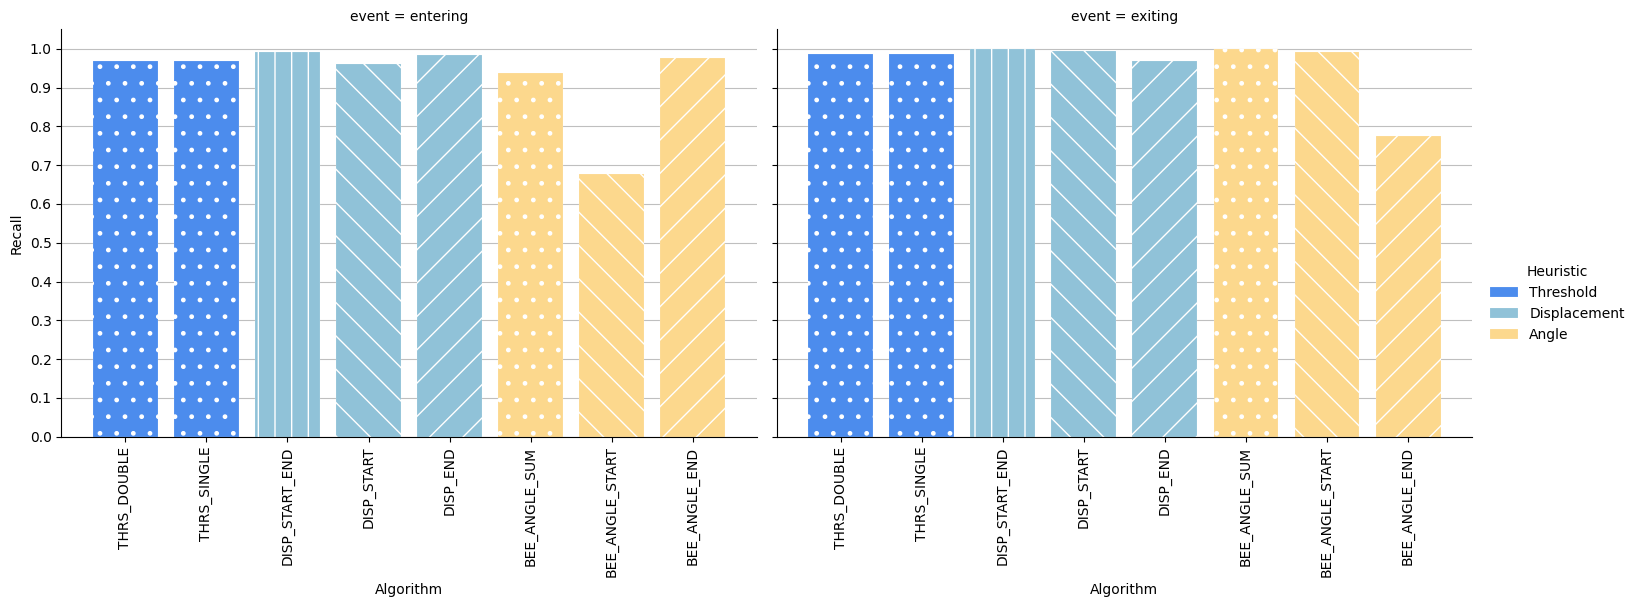

In [128]:
plot = sns.FacetGrid(df_simple, col="event", hue="class",height=5, aspect=1.5,palette=full_palette)
plot.map(plt.bar,'algorithm','accuracy',edgecolor='white',linewidth=0.1)

plot.add_legend(title="Heuristic")


for ax in plot.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    #for i,thisbar in enumerate(ax.patches):
     #   thisbar.set_hatch(hatches[i])
    ax.set_axisbelow(True)

    bars = ax.patches
    hatch_classes = df_simple['hatch']

    num_hatches = len(hatch_classes)

    for i, cls in enumerate(hatch_classes):
        hatch = hatch_map.get(cls, "")
        for b in bars[i::num_hatches]:
            b.set_hatch(hatch)
    

plot.set_axis_labels(x_var="Algorithm", y_var="Recall")


plot.savefig("accuracy1.png",bbox_inches='tight') 

C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\2641533929.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\2641533929.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


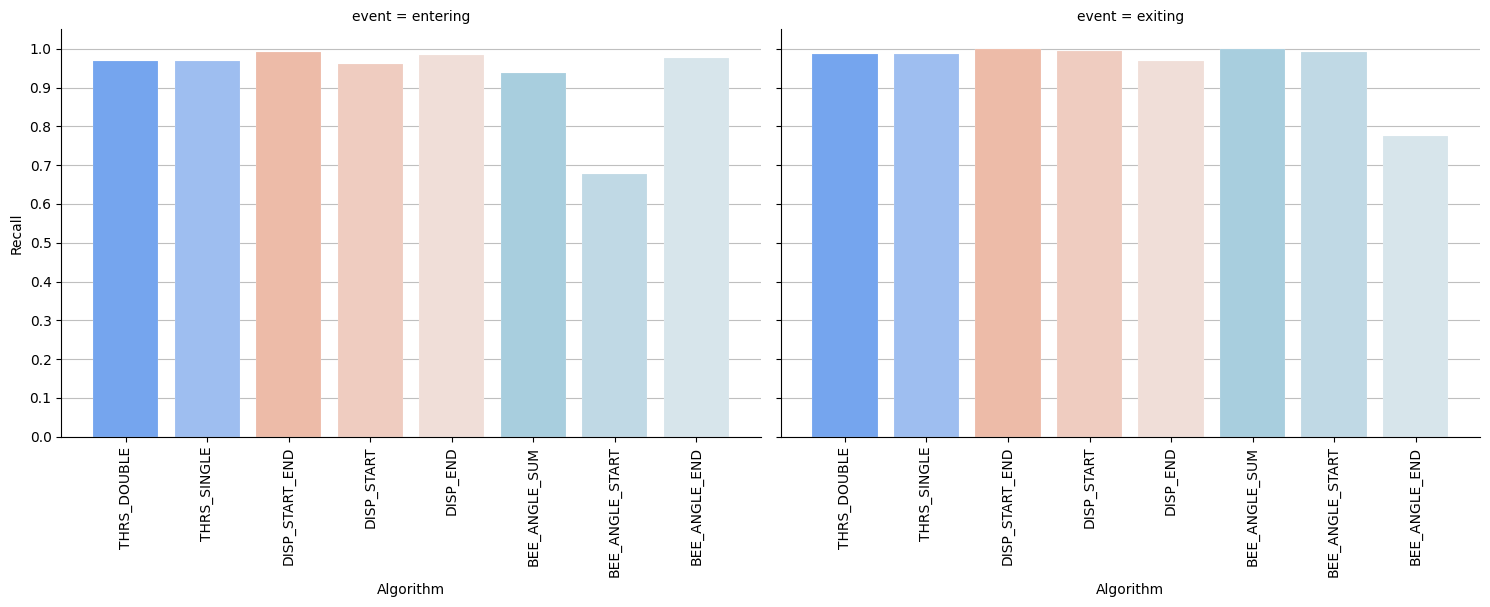

In [129]:
plot = sns.FacetGrid(df_simple, col="event", hue="algorithm",height=5, aspect=1.5,palette=palette)
plot.map(plt.bar,'algorithm','accuracy',edgecolor='white',linewidth=0.1)


for ax in plot.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    #for i,thisbar in enumerate(ax.patches):
     #   thisbar.set_hatch(hatches[i])
    ax.set_axisbelow(True)
    
plot.set_axis_labels(x_var="Algorithm", y_var="Recall")


plot.savefig("accuracy1-1.png",bbox_inches='tight') 

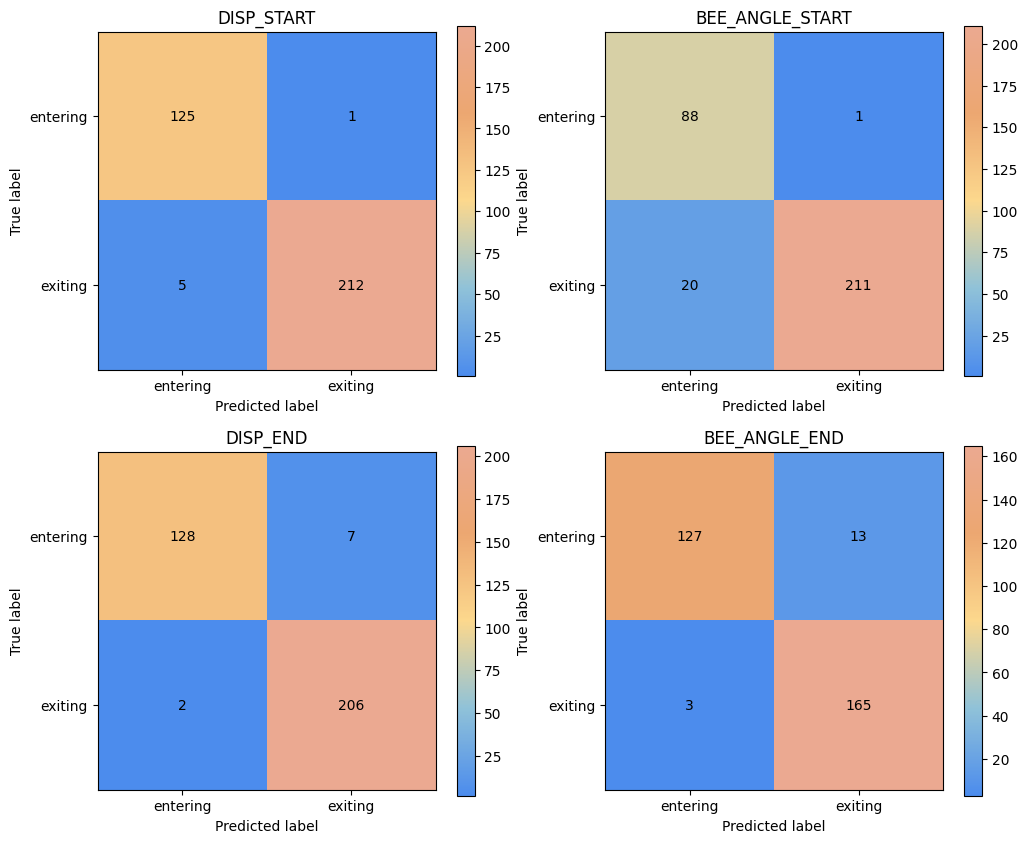

In [130]:
simple_matrix = pd.DataFrame.from_dict(for_matrix)
figure, axes = plt.subplots(2, 2,figsize=(12, 10))
columns = simple_matrix.drop(columns=['THRS_DOUBLE', 'DISP_START_END','BEE_ANGLE_SUM','THRS_SINGLE']).columns
for i in range(len(columns)):
    column = simple_matrix[columns[i]]
    cf_matrix = confusion_matrix(column, cheatsheet1['event'],labels=["entering", "exiting"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["entering", "exiting"])
    disp.plot(ax=axes[i%2,i//2], cmap=cmap)
    axes[i%2, i//2].set_title(columns[i])

    for text in disp.text_.flat: 
        text.set_color('black') 

plt.show()
figure.savefig("confusion1.png",bbox_inches='tight') 

In [131]:
len(cheatsheet1)

343

In [132]:
for col in simple_matrix.columns:
    print(f"\n=== Classification report for {col} ===")
    preds = simple_matrix[col]
    print(classification_report(
        cheatsheet1['event'],
        preds,
        target_names=["entering", "exiting"],
        labels=['entering','exiting']
    ))


=== Classification report for THRS_DOUBLE ===
              precision    recall  f1-score   support

    entering       1.00      0.97      0.98       130
     exiting       1.00      0.99      0.99       213

   micro avg       1.00      0.98      0.99       343
   macro avg       1.00      0.98      0.99       343
weighted avg       1.00      0.98      0.99       343


=== Classification report for THRS_SINGLE ===
              precision    recall  f1-score   support

    entering       1.00      0.97      0.98       130
     exiting       1.00      0.99      0.99       213

   micro avg       1.00      0.98      0.99       343
   macro avg       1.00      0.98      0.99       343
weighted avg       1.00      0.98      0.99       343


=== Classification report for DISP_START_END ===
              precision    recall  f1-score   support

    entering       1.00      0.99      1.00       130
     exiting       1.00      1.00      1.00       213

    accuracy                          

Recall for compound cases

In [133]:
#cheatsheet of compound events
#compare classifications against ground truth

cheatsheet2 = cheatsheet[cheatsheet['event'] != 'unknown']
enter_exit_count = len(cheatsheet[cheatsheet['event'] == 'entering-exiting'])
exit_enter_count = len(cheatsheet[cheatsheet['event'] == 'exiting-entering'])
individual_counts = {}
for_matrix2 = {}

functions = {
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle  
}

accuracy = {r: 0 for r in functions}
for APPROACHES, func in functions.items():
    individual_counts[APPROACHES] = {'entering-exiting':0,'exiting-entering':0,'entering':0,'exiting':0}

for APPROACHES, func in functions.items():
    for_matrix2[APPROACHES] = []
    
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]

    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        for_matrix2[APPROACHES].append(result)
        if result == event and event != 'unknown':
            individual_counts[APPROACHES][event] += 1
            accuracy[APPROACHES] += 1



In [134]:
results = {k: v/len(cheatsheet2) for k, v in accuracy.items()}
results

{'THRS_BIDIRECTIONAL': 0.9823717948717948,
 'DISP_BIDIRECTIONAL': 0.8557692307692307,
 'BEE_ANGLE_BIDIRECTIONAL': 0.625}

In [135]:
df_compound = pd.DataFrame.from_dict(individual_counts).transpose().reset_index()
divisors = {'entering':entering_count, 'exiting':exiting_count, 'entering-exiting':enter_exit_count, 'exiting-entering':exit_enter_count}
for i in df_compound.columns:
    if i == 'index':
        continue
    df_compound[i] = df_compound[i]/divisors[i]

df_compound = pd.melt(df_compound, id_vars=['index'], value_vars=divisors.keys())
df_compound = df_compound.rename(columns={"index": "algorithm", "variable": "event", "value": "accuracy"})


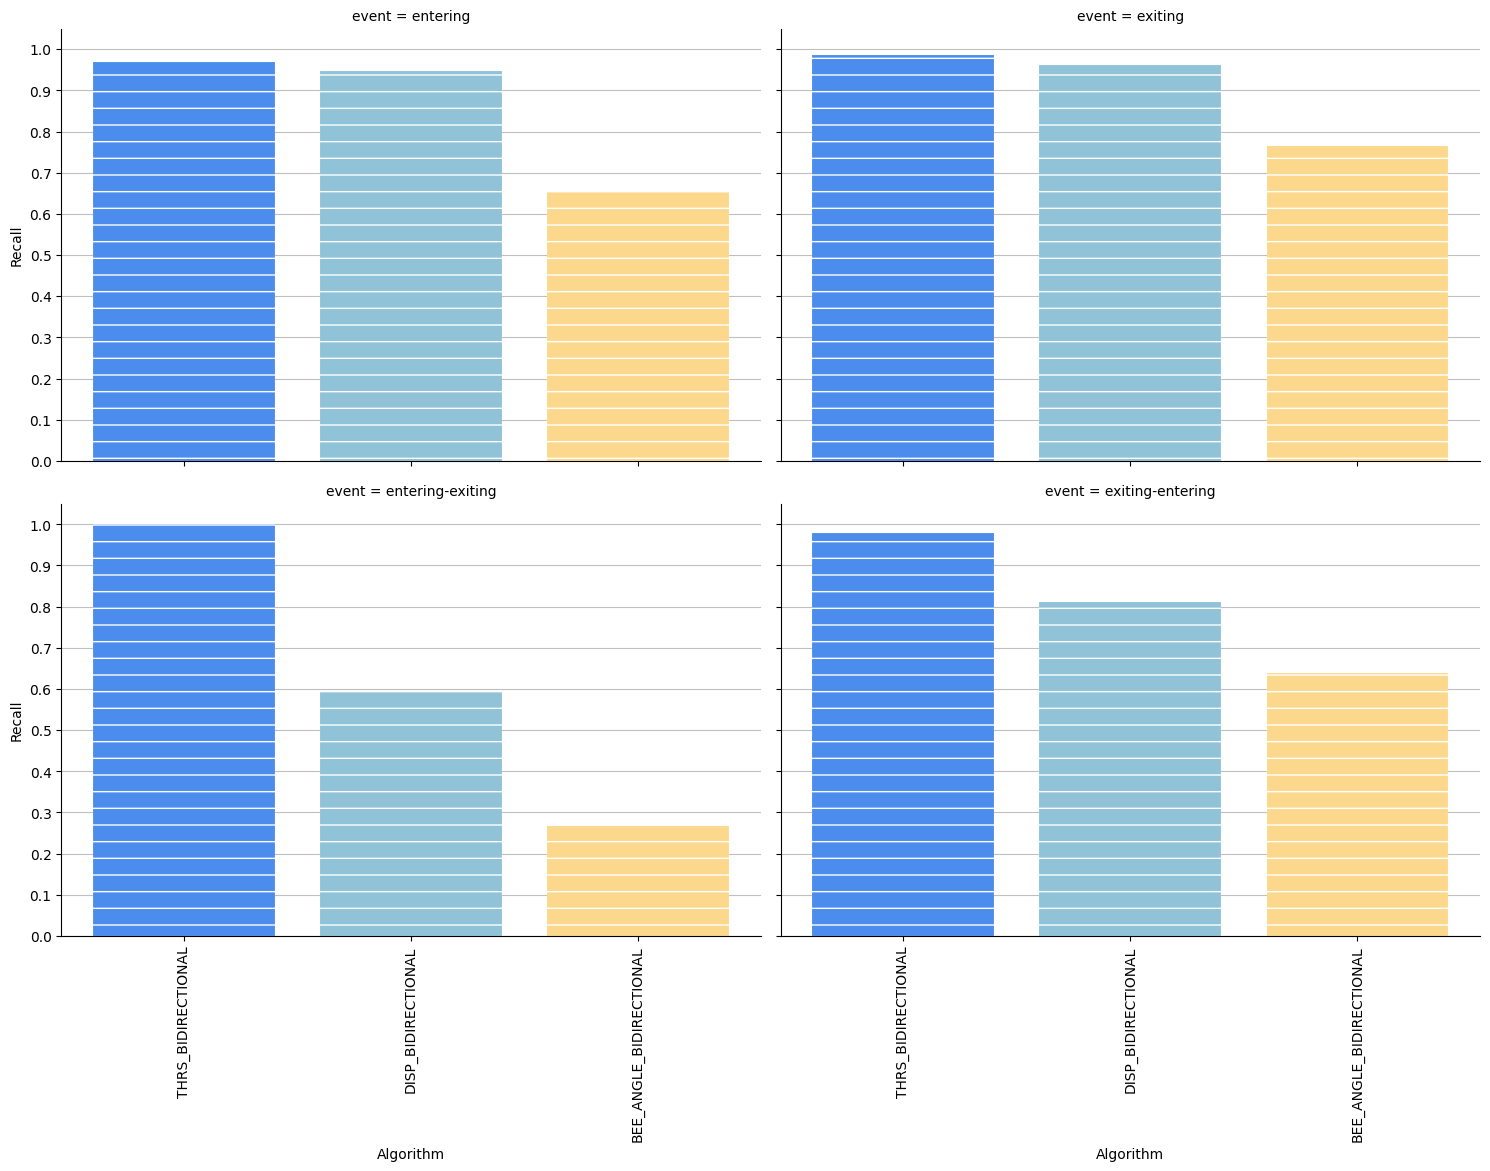

In [136]:
plot = sns.FacetGrid(df_compound, col="event", hue="algorithm",height=5, aspect=1.5,col_wrap=2,palette=full_palette)
plot.map(plt.bar,'algorithm','accuracy',edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

    bars = ax.patches
    for b in bars:
        b.set_hatch('-')

plot.set_axis_labels(x_var="Algorithm", y_var="Recall")



plot.savefig("accuracy2.png",bbox_inches='tight') 


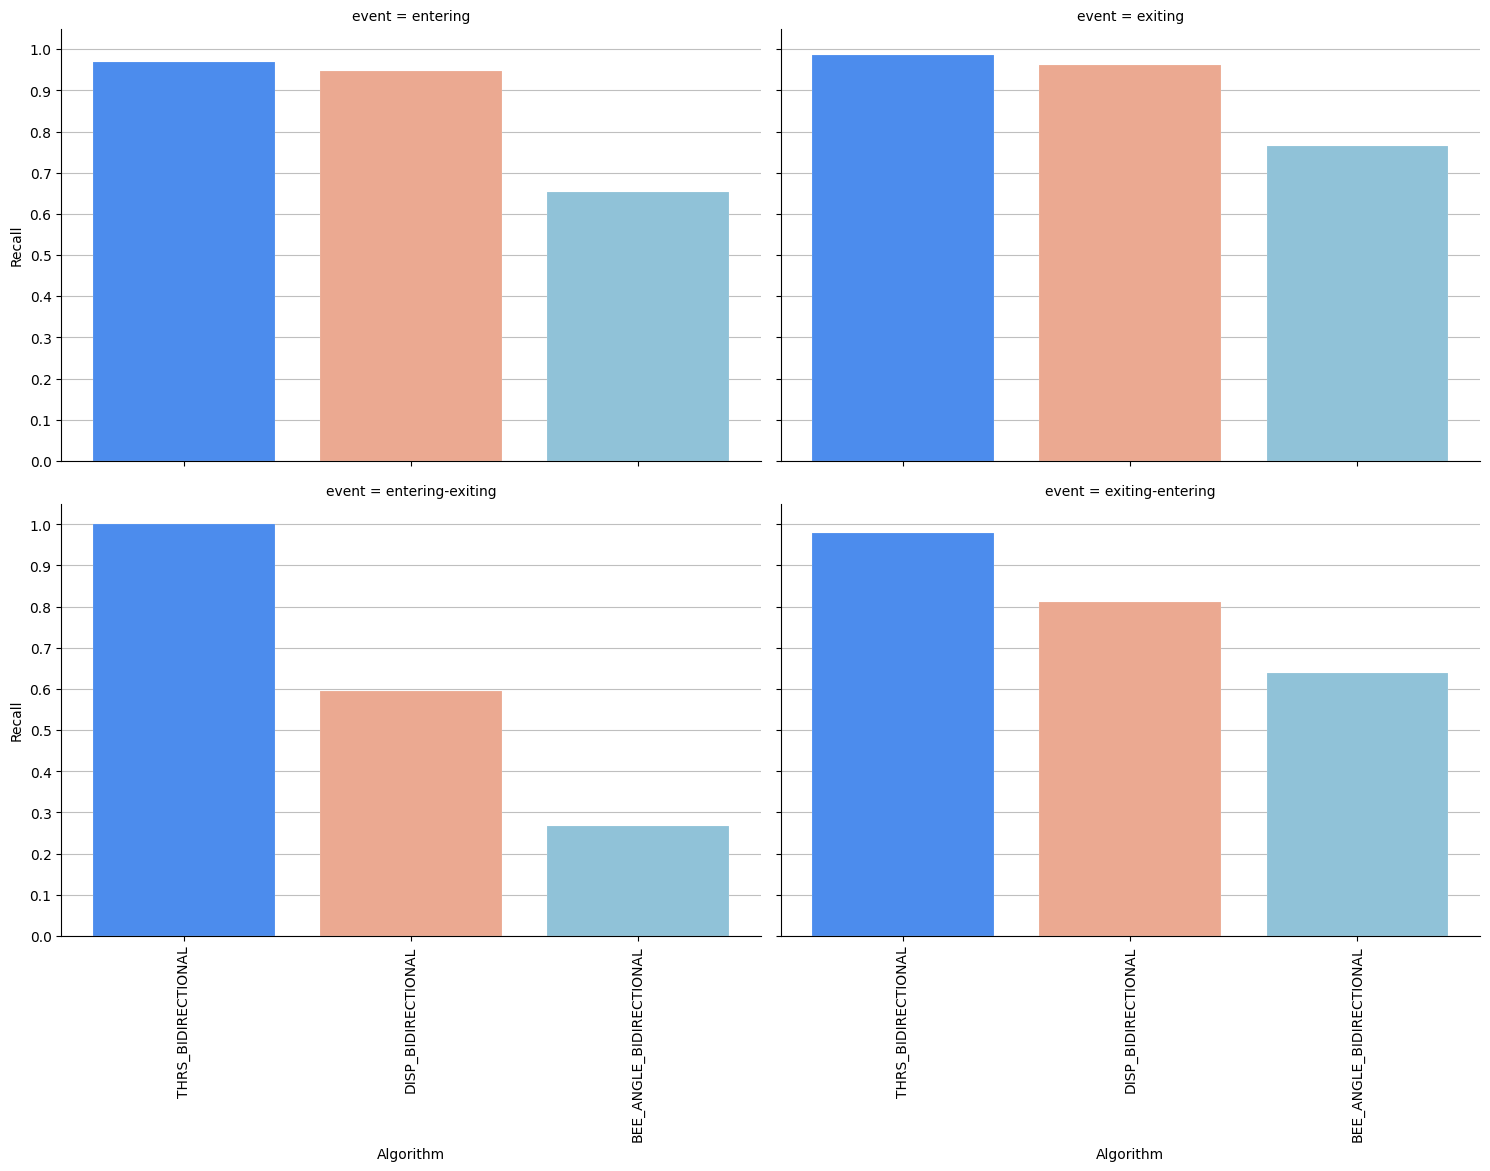

In [137]:
plot = sns.FacetGrid(df_compound, col="event", hue="algorithm",height=5, aspect=1.5,col_wrap=2,palette=palette)
plot.map(plt.bar,'algorithm','accuracy',edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="Recall")



plot.savefig("accuracy2-1.png",bbox_inches='tight') 


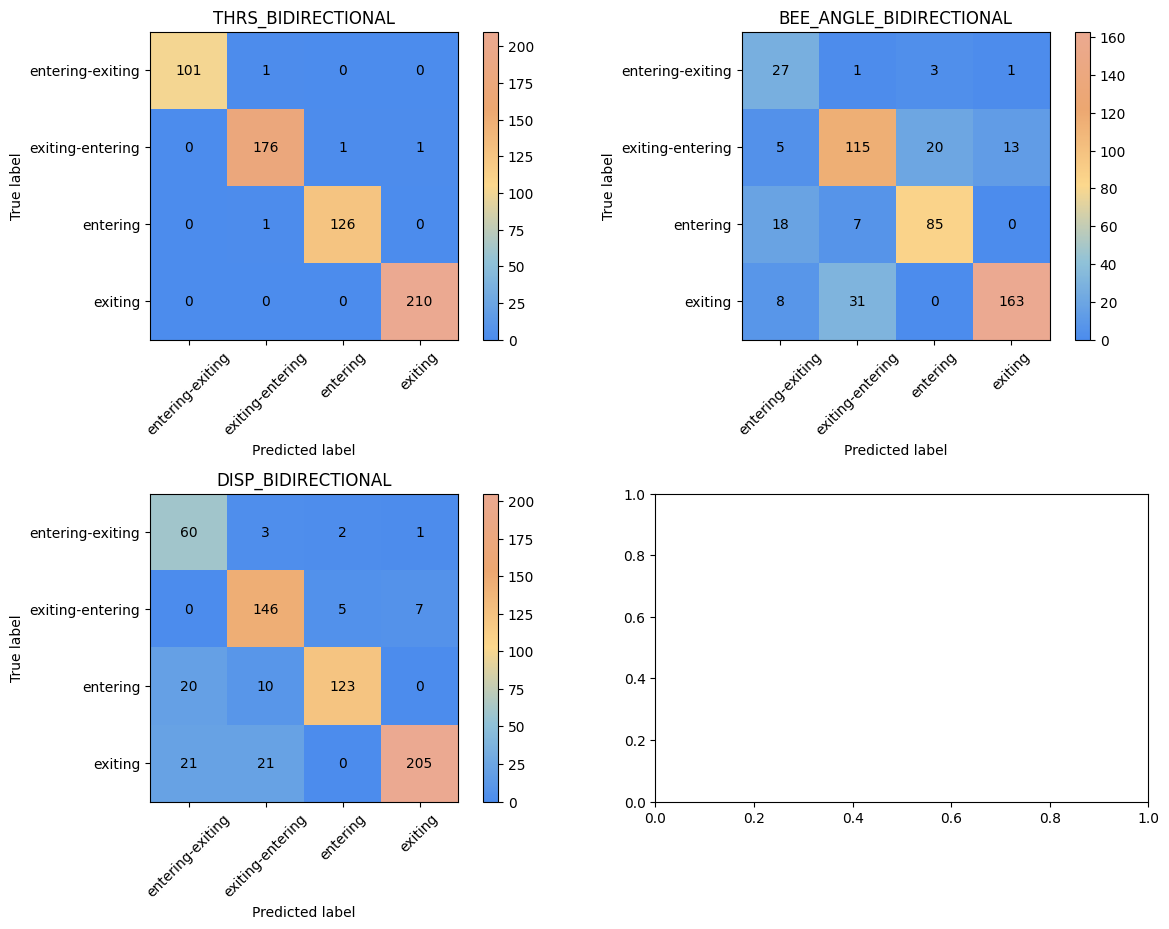

In [138]:
compound_matrix = pd.DataFrame.from_dict(for_matrix2)
figure, axes = plt.subplots(2, 2,figsize=(14, 10))
figure.subplots_adjust(hspace=0.5)
columns = compound_matrix.columns
for i in range(len(columns)):
    column = compound_matrix[columns[i]]
    column = column.fillna("entering-exiting")
    cf_matrix = confusion_matrix(column, cheatsheet2['event'],labels=["entering-exiting", "exiting-entering","entering","exiting"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["entering-exiting", "exiting-entering","entering","exiting"])
    disp.plot(ax=axes[i%2,i//2],cmap=cmap)
    axes[i%2, i//2].set_title(columns[i])
    axes[i % 2, i // 2].tick_params(axis='x', labelrotation=45)
    for text in disp.text_.flat: 
        text.set_color('black') 
plt.show()
figure.savefig("confusion2.png")

In [139]:
for col in compound_matrix.columns:
    print(f"\n=== Classification report for {col} ===")
    column = compound_matrix[col]
    column = column.where(
        column != third_class,
        cheatsheet2['event'].map({
            "entering-exiting": "exiting-entering",
            "exiting-entering": "entering-exiting",
            "entering":"exiting",
            "exiting":"entering",
            third_class: "entering-exiting"
        })
    )
    column = column.fillna("entering-exiting")
    
    print(classification_report(
        cheatsheet2['event'],
        column,
        target_names=["entering-exiting", "exiting-entering","entering","exiting"]
    ))


=== Classification report for THRS_BIDIRECTIONAL ===
                  precision    recall  f1-score   support

entering-exiting       0.98      0.98      0.98       130
exiting-entering       0.95      1.00      0.98       101
        entering       1.00      0.99      0.99       213
         exiting       0.99      0.98      0.98       180

        accuracy                           0.98       624
       macro avg       0.98      0.99      0.98       624
    weighted avg       0.98      0.98      0.98       624


=== Classification report for DISP_BIDIRECTIONAL ===
                  precision    recall  f1-score   support

entering-exiting       0.80      0.95      0.87       130
exiting-entering       0.91      0.59      0.72       101
        entering       0.83      0.96      0.89       213
         exiting       0.92      0.81      0.86       180

        accuracy                           0.86       624
       macro avg       0.87      0.83      0.84       624
    weighted avg 

## DIVERGENCE SCORE

Tested on regular simple cases

In [140]:
APPROACHES_names = ['THRS_DOUBLE', 'THRS_SINGLE','DISP_START_END', 'DISP_START','DISP_END', 'BEE_ANGLE_SUM',
              'BEE_ANGLE_START','BEE_ANGLE_END']
complement = {APPROACHES: {rr: 0 for rr in APPROACHES_names} for APPROACHES in APPROACHES_names}
for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]
    #APPROACHESs
    APPROACHESs = {
    'THRS_DOUBLE': in_out(detections),
    'THRS_SINGLE': in_out_single(detections),
    'DISP_START_END': displacementinit(detections),
    'DISP_START': displacement2(detections),
    'DISP_END': displacement(detections),
    'BEE_ANGLE_SUM': angles(detections),
    'BEE_ANGLE_START': firstangle(detections),
    'BEE_ANGLE_END': lastangle(detections),
    }

    for key, value in APPROACHESs.items():
        for otherAPPROACHES, othervalue in APPROACHESs.items():
            #compare if APPROACHES's classification is different from previous APPROACHES
            if otherAPPROACHES != key and othervalue != value:
                complement[key][otherAPPROACHES] += 1
   


In [141]:
#X axis -> Y axis
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet1)
df
mask = np.triu(np.ones(df.shape, dtype=bool))

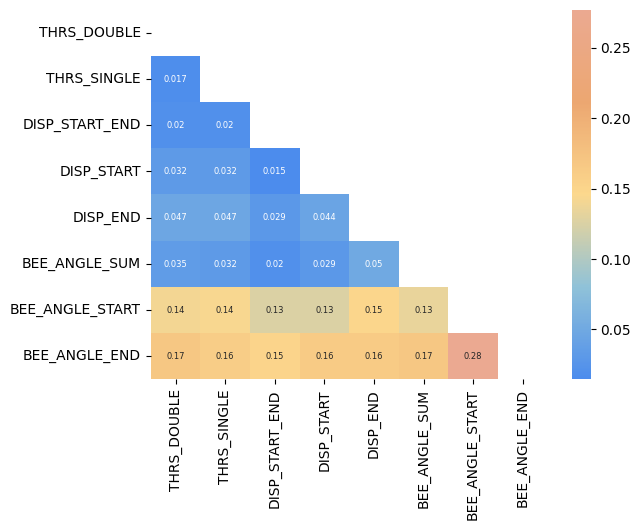

In [142]:
plot = sns.heatmap(df, annot=True,annot_kws={"size": 6}, mask=mask,cmap=cmap)
fig = plot.get_figure()
fig.savefig("divergencescore1.png",bbox_inches='tight') 

Cheatsheet with compound cases

In [143]:
APPROACHES_names = ['THRS_BIDIRECTIONAL','DISP_BIDIRECTIONAL','BEE_ANGLE_BIDIRECTIONAL' ]
complement = {APPROACHES: {rr: 0 for rr in APPROACHES_names} for APPROACHES in APPROACHES_names}
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]
    #APPROACHESs
    APPROACHESs = {
    'THRS_BIDIRECTIONAL':in_out2(detections),
    'DISP_BIDIRECTIONAL':displacementbackforth(detections),
    'BEE_ANGLE_BIDIRECTIONAL':lastfirstangle(detections)
    }

    for key, value in APPROACHESs.items():
        for otherAPPROACHES, othervalue in APPROACHESs.items():
            if otherAPPROACHES != key and othervalue != value:
                complement[key][otherAPPROACHES] += 1
   


In [144]:
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet2)
df
mask = np.triu(np.ones(df.shape, dtype=bool))

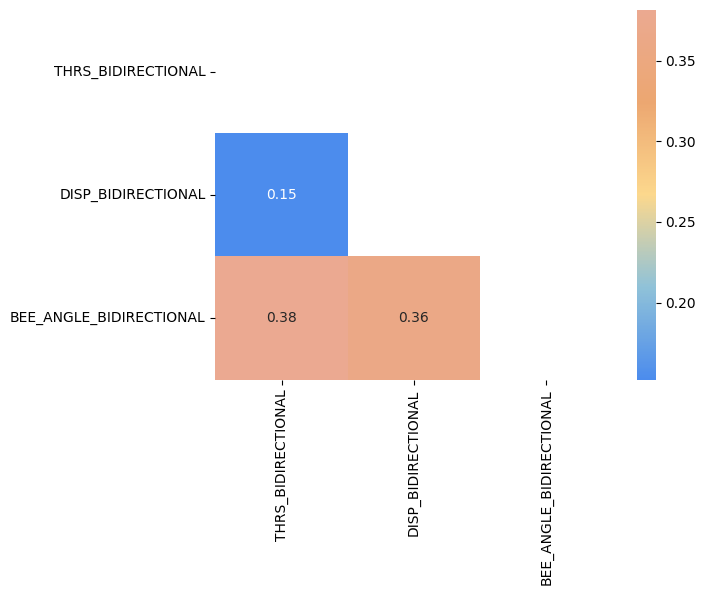

In [145]:
plot = sns.heatmap(df, annot=True,mask=mask,cmap = cmap)
fig = plot.get_figure()
fig.savefig("divergencescore2.png",bbox_inches='tight') 

## Global precision and accuracy

In [147]:

removed = ['unknown']
global_classes = {}
global_accuracy = {}

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_SUM': angles,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle
    
}


for APPROACHES, func in functions.items():
    global_classes[APPROACHES] = []
    global_accuracy[APPROACHES] = 0
    
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]

    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        global_classes[APPROACHES].append(result)
        if event == result:
            global_accuracy[APPROACHES] += 1
      
        

In [148]:
df_global = pd.DataFrame.from_dict(global_classes)

In [149]:
labels = ["entering", "exiting","entering-exiting", "exiting-entering"]

global_classes = {
    "precision": {},
    "recall": {},
    "f1":{}
}

for APPROACHES, func in functions.items():
    global_classes['recall'][APPROACHES] = {}
    global_classes['precision'][APPROACHES] = {}

for column in df_global.columns:
    precision = precision_score(
    df_global[column], 
    cheatsheet2['event'], 
    average=None, 
    labels=labels
    )

    global_classes['precision'][column] = {labels[i]: precision[i] for i in range(len(labels))}

    recall = recall_score(
    df_global[column], 
    cheatsheet2['event'], 
    average=None, 
    labels=labels
    )

    global_classes['recall'][column] = {labels[i]: recall[i] for i in range(len(labels))}

    f1 = f1_score(
    df_global[column], 
    cheatsheet2['event'], 
    average=None, 
    labels=labels
    )

    global_classes['f1'][column] = {labels[i]: f1[i] for i in range(len(labels))}


df_recall = pd.DataFrame.from_dict(global_classes['recall']).reset_index()
df_precision = pd.DataFrame.from_dict(global_classes['precision']).reset_index()
df_f1 = pd.DataFrame.from_dict(global_classes['f1']).reset_index()

C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local

In [150]:
df_precision_melted = pd.melt(df_precision, id_vars=['index'],value_vars=functions.keys())
df_recall_melted = pd.melt(df_recall, id_vars=['index'],value_vars=functions.keys())
df_f1_melted = pd.melt(df_f1, id_vars=['index'],value_vars=functions.keys())

df_precision_melted['metric'] = 'precision'
df_recall_melted['metric'] = 'recall'
df_f1_melted['metric'] = 'f1'

df_full = pd.concat([df_f1_melted, df_recall_melted,df_precision_melted])
df_full

,index,variable,value,metric
0,entering,THRS_DOUBLE,0.980545,f1
1,exiting,THRS_DOUBLE,0.992908,f1
2,entering-exiting,THRS_DOUBLE,0.000000,f1
3,exiting-entering,THRS_DOUBLE,0.000000,f1
4,entering,THRS_SINGLE,0.984375,f1
...,...,...,...,...
39,exiting-entering,DISP_BIDIRECTIONAL,0.811111,precision
40,entering,BEE_ANGLE_BIDIRECTIONAL,0.653846,precision
41,exiting,BEE_ANGLE_BIDIRECTIONAL,0.765258,precision
42,entering-exiting,BEE_ANGLE_BIDIRECTIONAL,0.267327,precision


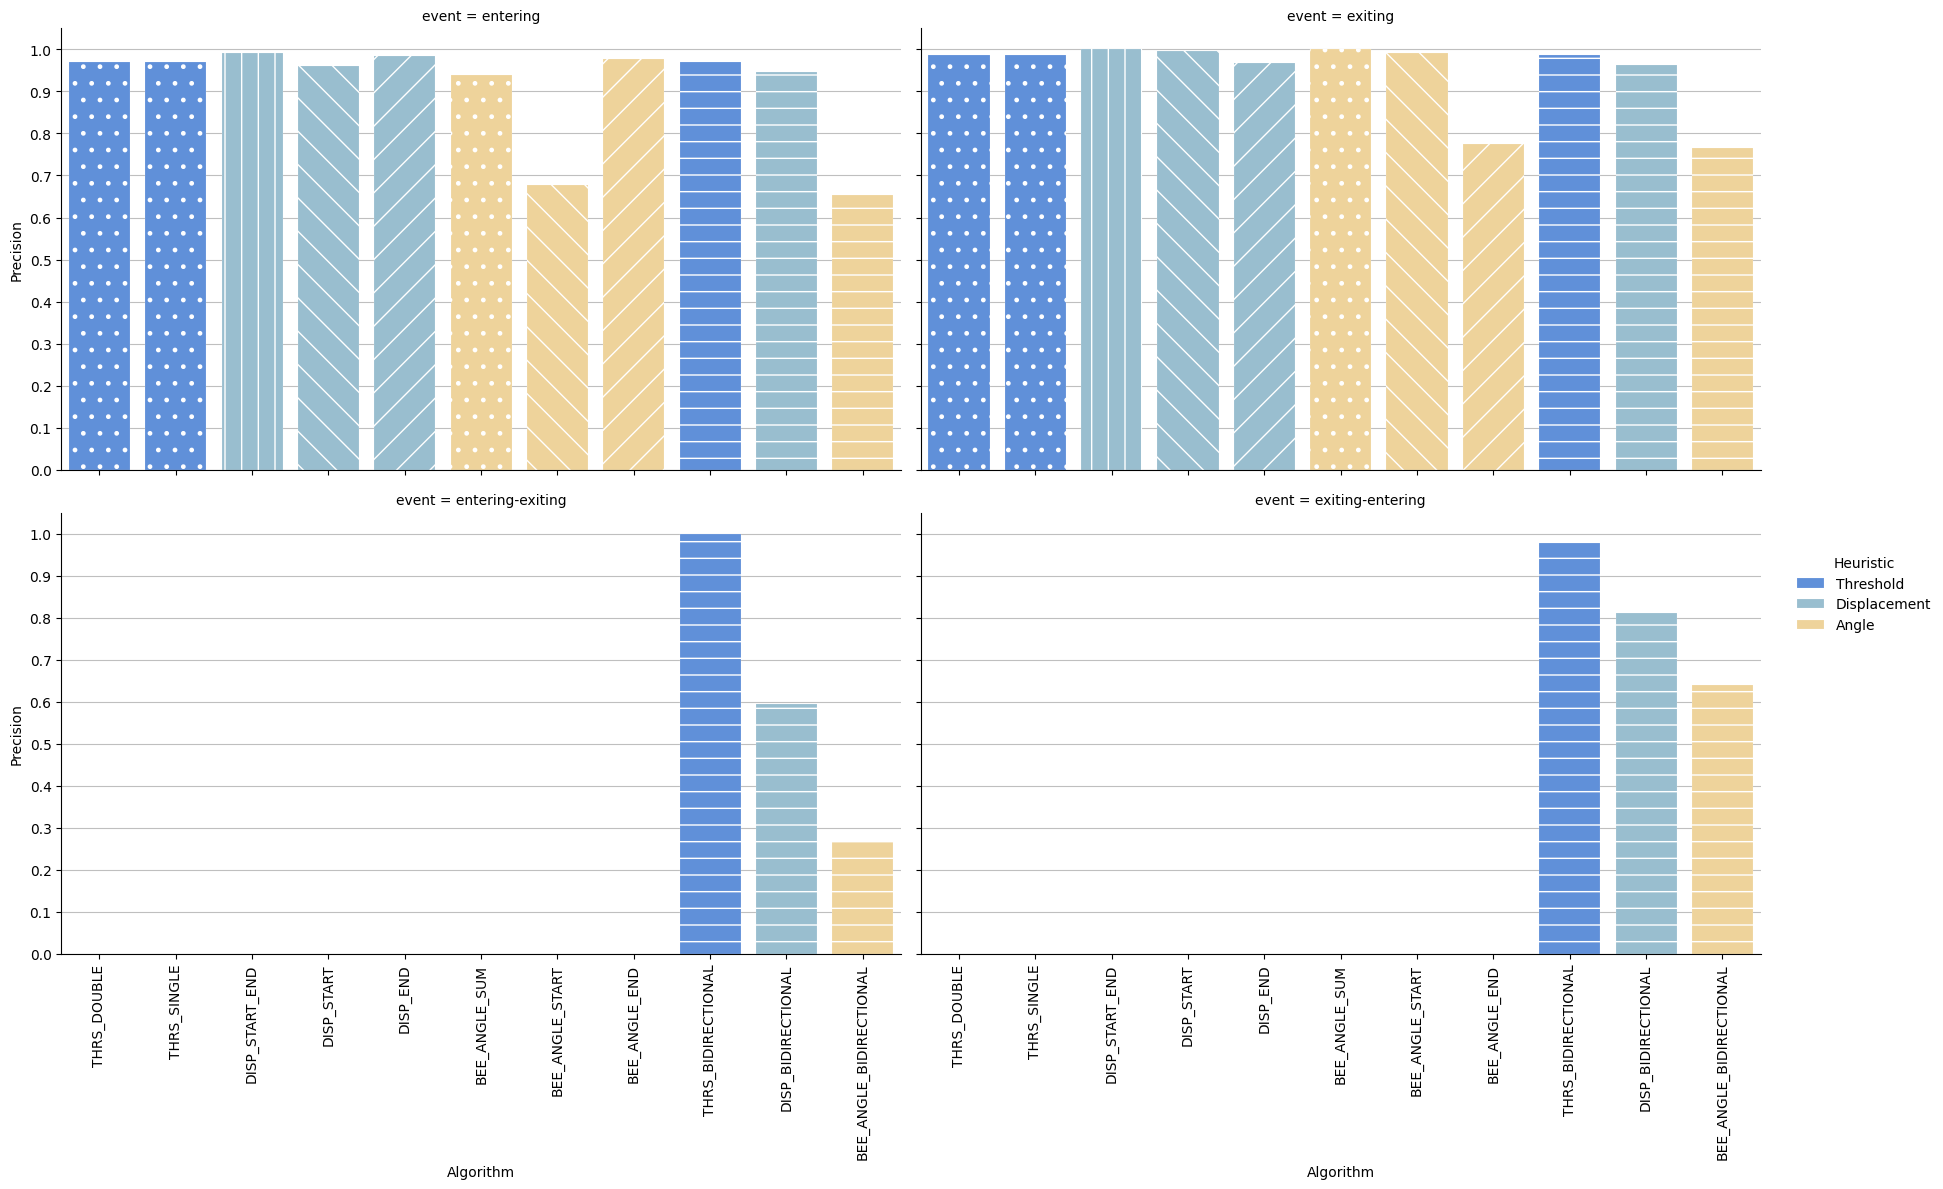

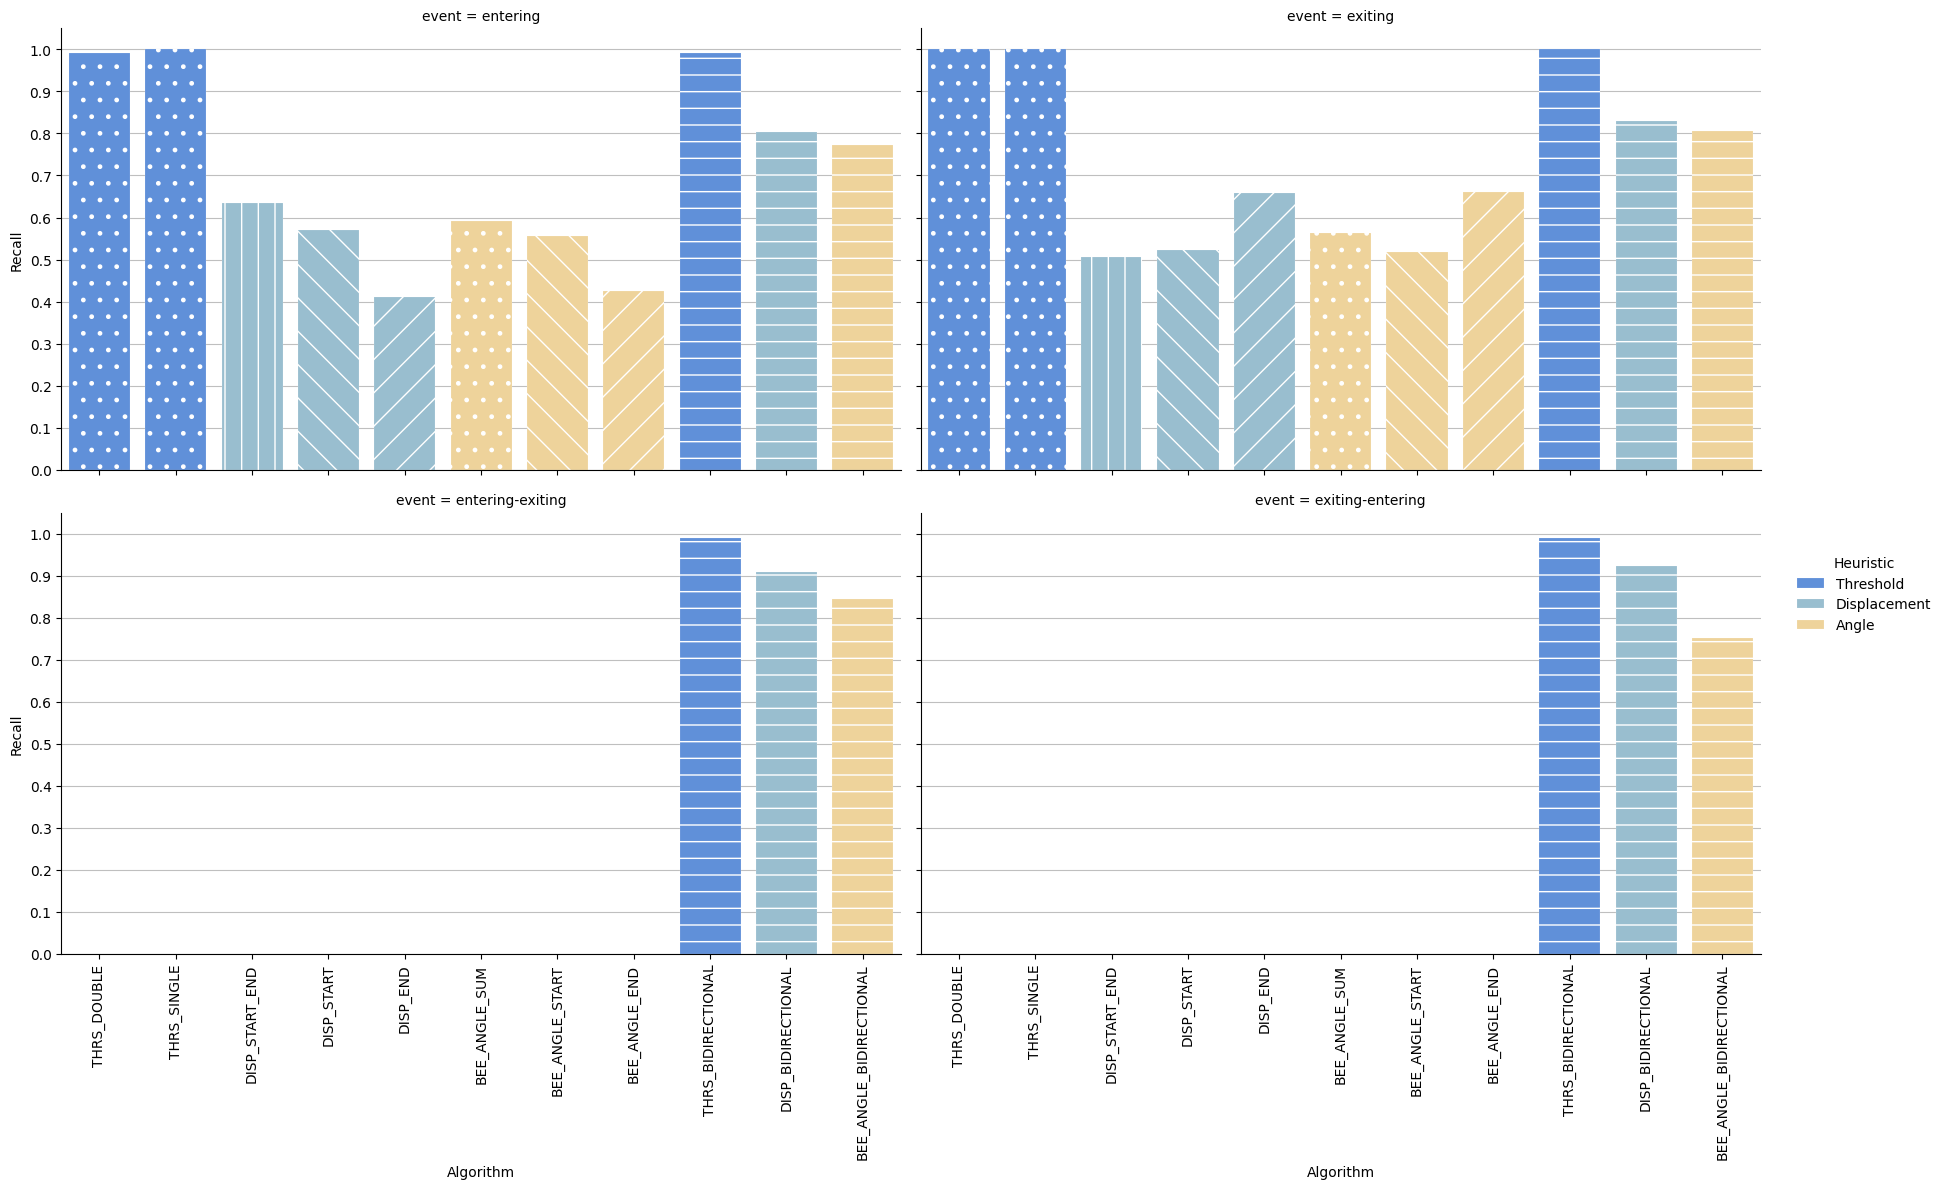

In [155]:

hatches10 = ['.','.','|','\\','/','.','\\','/','-','-','-']
df_precision_melted = df_precision_melted.rename(columns={"index": "event", "variable": "algorithm", "value": "precision"})
df_precision_melted['class'] = df_precision_melted['algorithm'].apply(lambda x: classify_algo(x))

df_recall_melted = df_recall_melted.rename(columns={"index": "event", "variable": "algorithm", "value": "recall"})
df_recall_melted['class'] = df_recall_melted['algorithm'].apply(lambda x: classify_algo(x))

plot = sns.FacetGrid(df_precision_melted, col="event", hue="class",height=6, aspect=1.5,col_wrap=2,palette=full_palette)
plot.map(sns.barplot,'algorithm','precision',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="Precision")
plot.add_legend(title="Heuristic") 
plot.tight_layout()  



for ax in plot.axes.flat:
    # Loop over the bars
    bars = sorted(ax.patches, key=lambda b: (b.get_x(), b.get_y()))
    for i,thisbar in enumerate(bars):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches10[i])


plot.savefig("precisionglobal.png",bbox_inches='tight') 

plot = sns.FacetGrid(df_recall_melted, col="event", hue="class",height=6, aspect=1.5,col_wrap=2,palette=full_palette)
plot.map(sns.barplot,'algorithm','recall',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.add_legend(title="Heuristic")
for ax in plot.axes.flat:
    # Loop over the bars
    bars = sorted(ax.patches, key=lambda b: (b.get_x(), b.get_y()))
    for i,thisbar in enumerate(bars):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches10[i])


plot.set_axis_labels(x_var="Algorithm", y_var="Recall") 
plot.tight_layout()  

plot.savefig("recallglobal.png",bbox_inches='tight') 

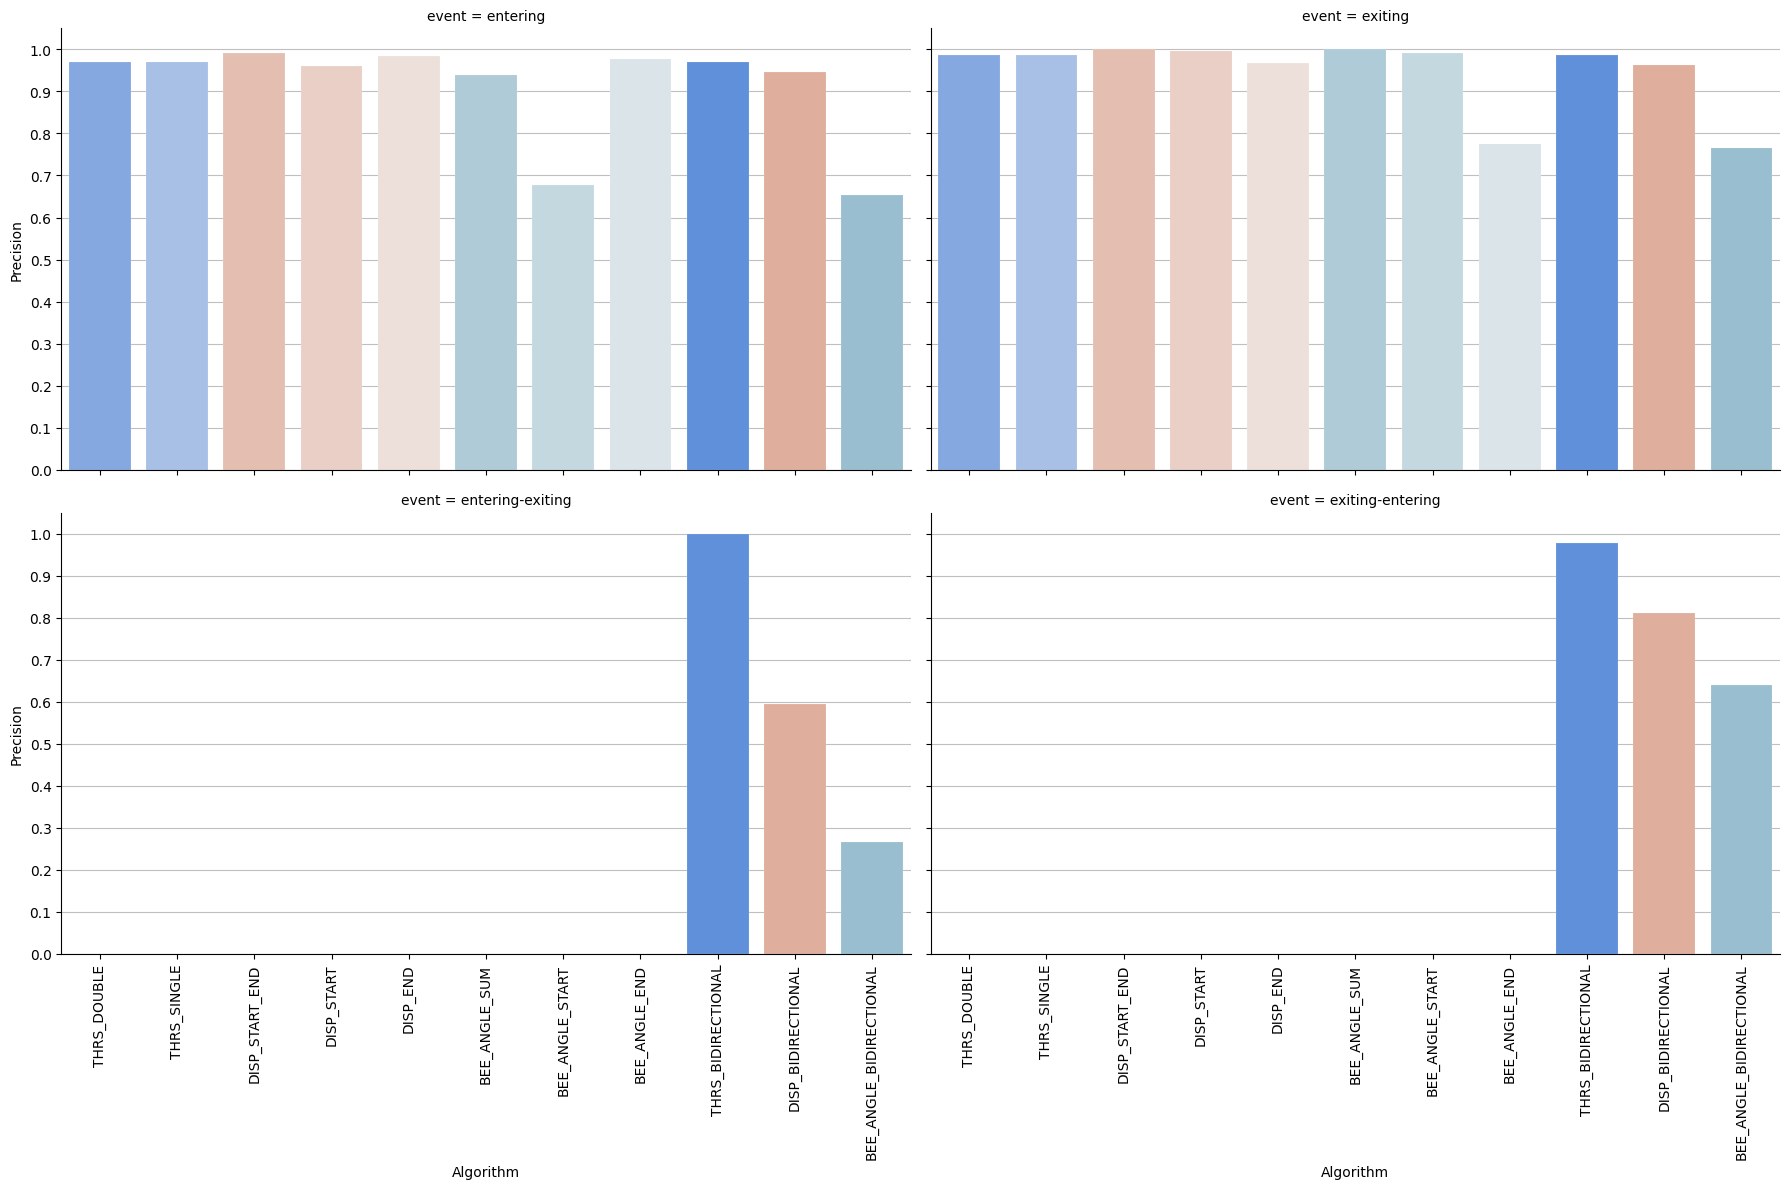

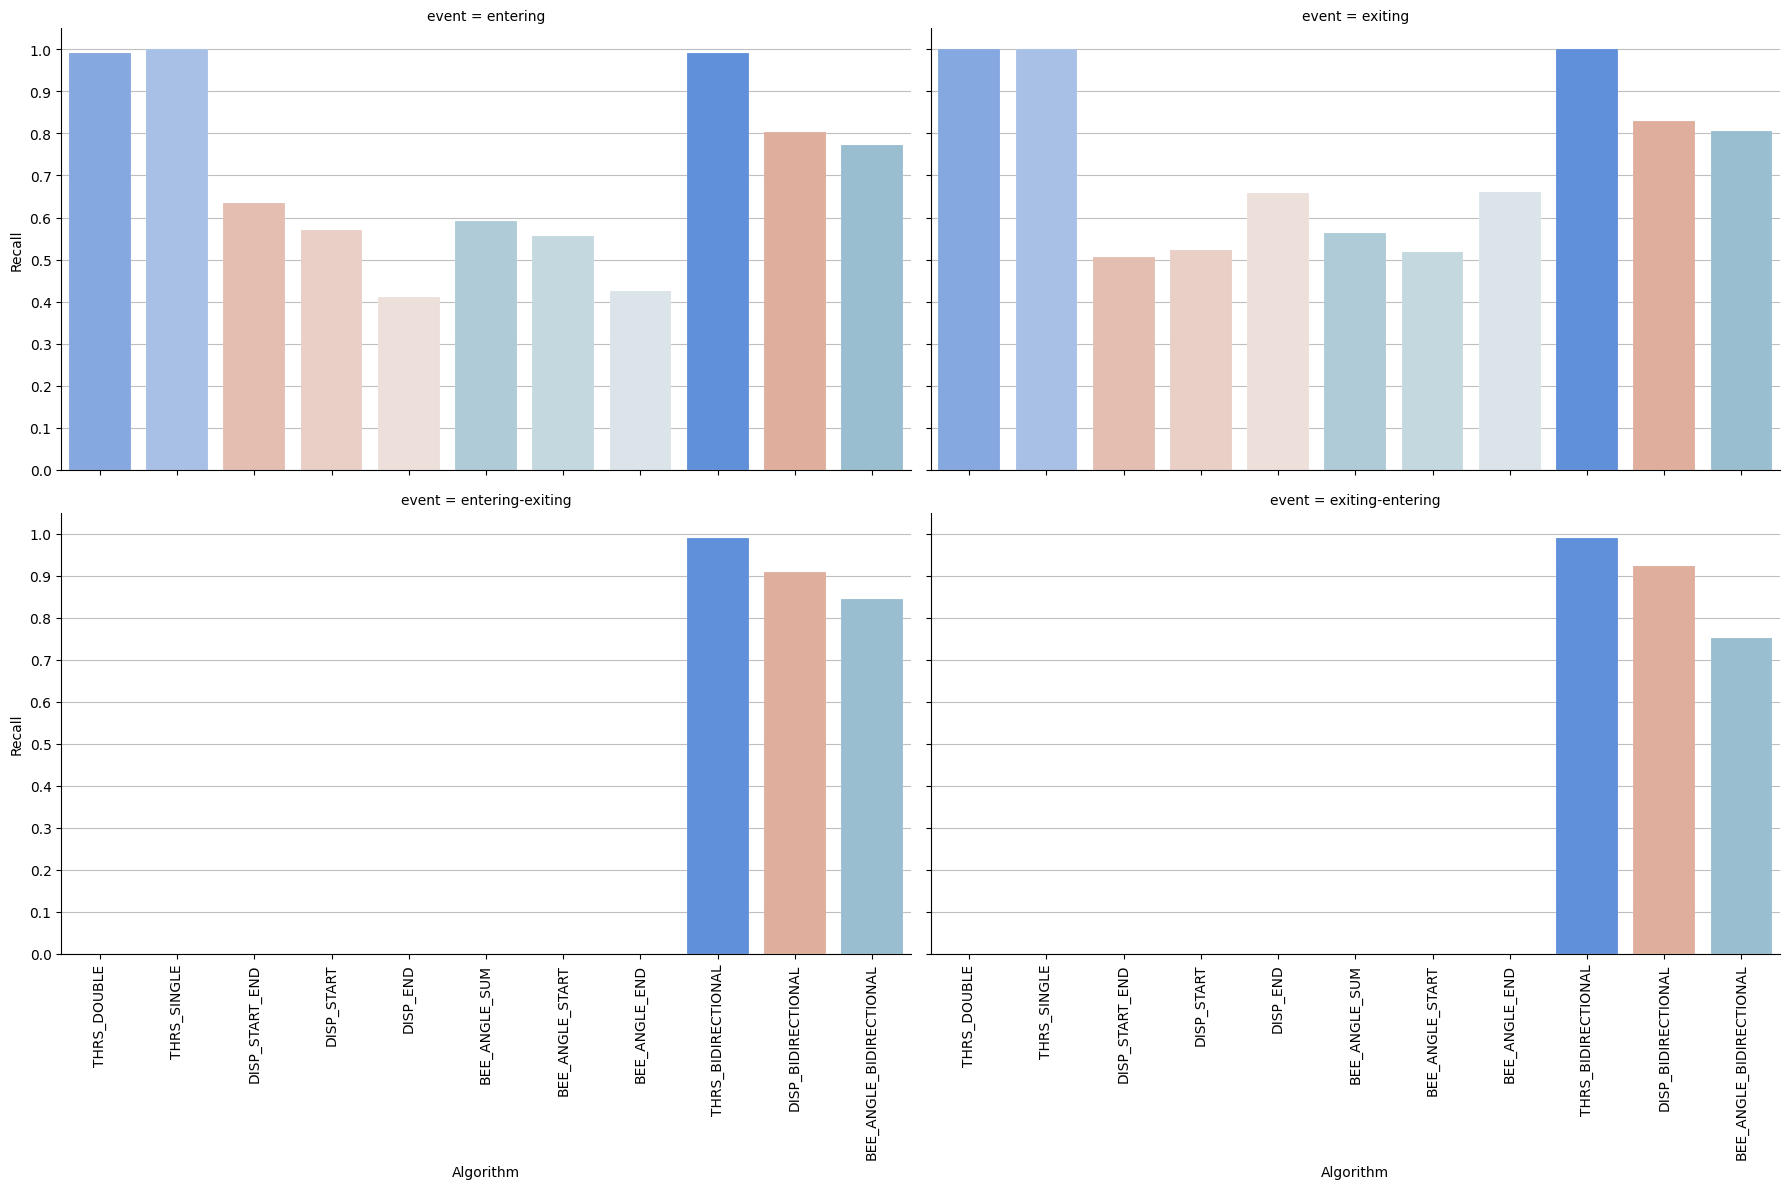

In [156]:

df_precision_melted = df_precision_melted.rename(columns={"index": "event", "variable": "algorithm", "value": "precision"})
df_precision_melted['class'] = df_precision_melted['algorithm'].apply(lambda x: classify_algo(x))

df_recall_melted = df_recall_melted.rename(columns={"index": "event", "variable": "algorithm", "value": "recall"})
df_recall_melted['class'] = df_recall_melted['algorithm'].apply(lambda x: classify_algo(x))

plot = sns.FacetGrid(df_precision_melted, col="event", hue="algorithm",height=6, aspect=1.5,col_wrap=2,palette=palette)
plot.map(sns.barplot,'algorithm','precision',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="Precision")
plot.tight_layout()  


plot.savefig("precisionglobal-1.png",bbox_inches='tight') 

plot = sns.FacetGrid(df_recall_melted, col="event", hue="algorithm",height=6, aspect=1.5,col_wrap=2,palette=palette)
plot.map(sns.barplot,'algorithm','recall',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="Recall") 
plot.tight_layout()  

plot.savefig("recallglobal-1.png",bbox_inches='tight') 

## GLOBAL ACCURACY

C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\1008381119.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


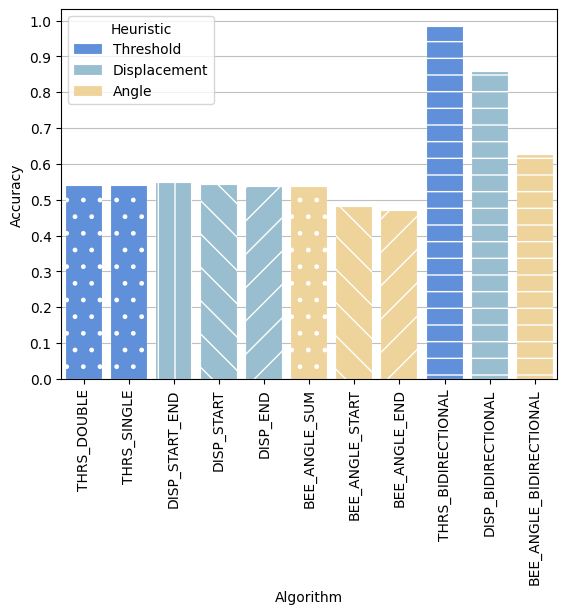

In [157]:
accuracy = {k: v/len(cheatsheet2) for k, v in global_accuracy.items()}
algos = list(accuracy.keys())  
hues = [classify_algo(x) for x in algos]
hatch_codes = [classify_hatch(x) for x in algos]
patterns = [hatch_map[c] for c in hatch_codes]



plot = sns.barplot(x=accuracy.keys(),y=accuracy.values(),hue=hues,edgecolor='white',linewidth=0.1)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.legend(title="Heuristic")
plot.set(xlabel='Algorithm', ylabel='Accuracy')

bars = [b for b in plot.patches if b.get_height() > 0]

bars = sorted(bars, key=lambda b: b.get_x())

for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plot.set_yticks(np.linspace(0,1,11))
plot.grid(True, axis="y", color="gray", alpha=0.5) 
plot.set_axisbelow(True)
fig = plot.get_figure()
fig.savefig("accuracyglobal.png",bbox_inches='tight')  


C:\Users\kashi\AppData\Local\Temp\ipykernel_11376\2148202955.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


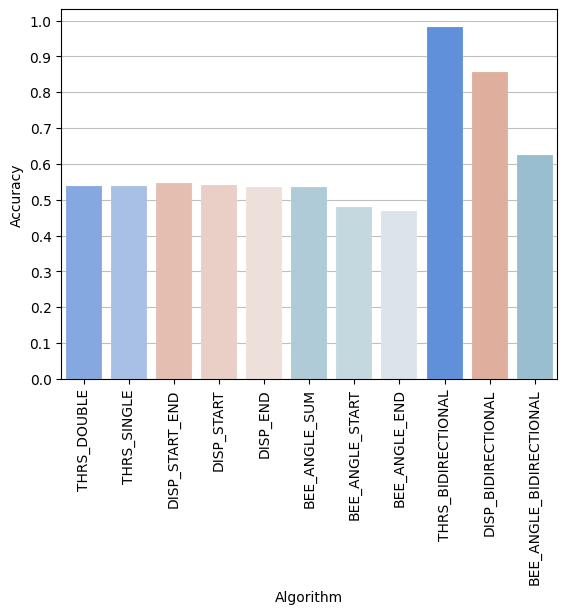

In [158]:
accuracy = {k: v/len(cheatsheet2) for k, v in global_accuracy.items()}
algos = list(accuracy.keys())  



plot = sns.barplot(x=accuracy.keys(),y=accuracy.values(),hue=algos,edgecolor='white',linewidth=0.1,palette=palette)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set(xlabel='Algorithm', ylabel='Accuracy')


plot.set_yticks(np.linspace(0,1,11))
plot.grid(True, axis="y", color="gray", alpha=0.5) 
plot.set_axisbelow(True)
fig = plot.get_figure()
fig.savefig("accuracyglobal-1.png",bbox_inches='tight')  


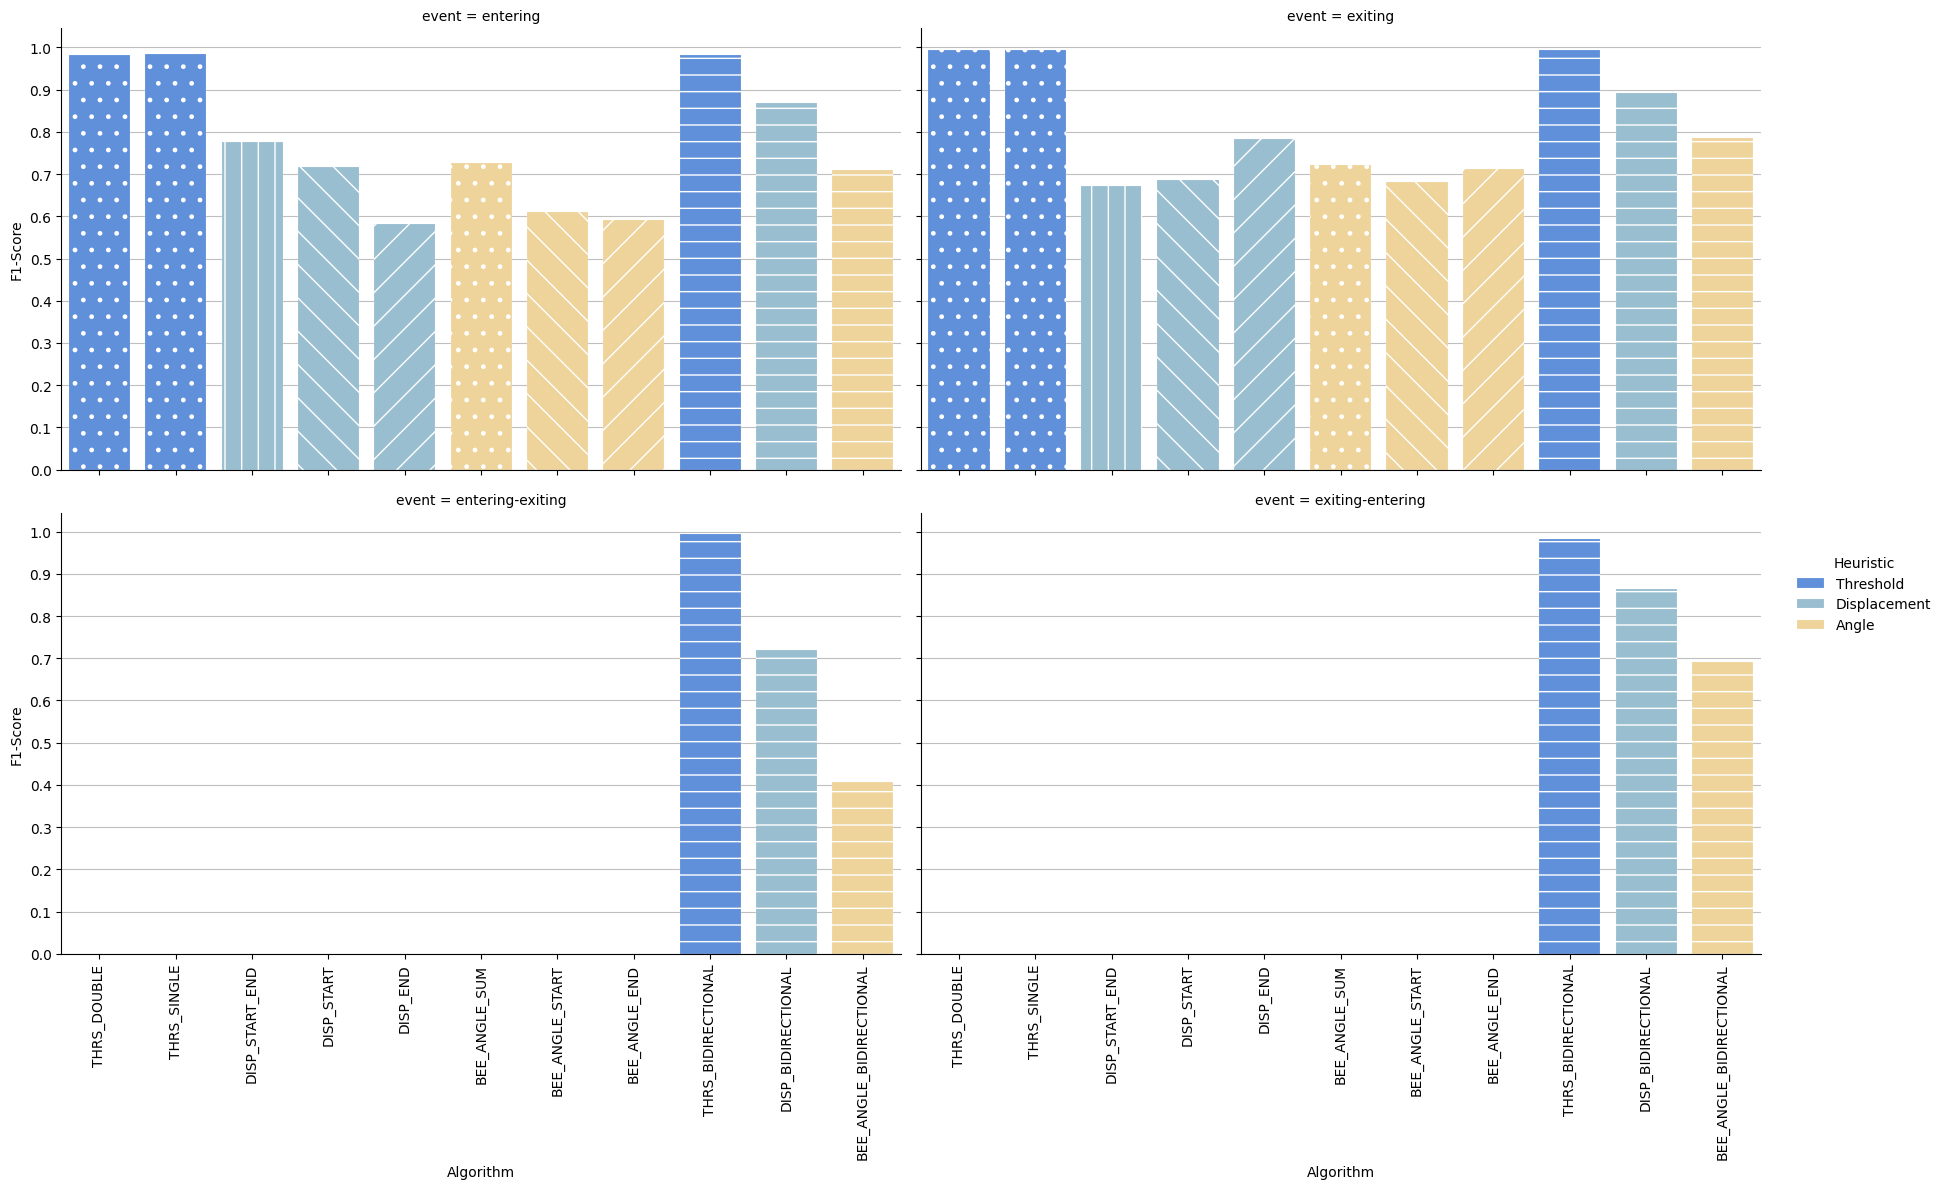

In [159]:
df_f1_melted = df_f1_melted.rename(columns={"index": "event", "variable": "algorithm", "value": "f1"})
df_f1_melted['class'] = df_f1_melted['algorithm'].apply(lambda x: classify_algo(x))

plot = sns.FacetGrid(df_f1_melted, col="event", hue="class",height=6, aspect=1.5,col_wrap=2,palette=full_palette)
plot.map(sns.barplot,'algorithm','f1',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="F1-Score")
plot.add_legend(title="Heuristic") 
plot.tight_layout()  



for ax in plot.axes.flat:
    # Loop over the bars
    bars = sorted(ax.patches, key=lambda b: (b.get_x(), b.get_y()))
    for i,thisbar in enumerate(bars):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches10[i])


plot.savefig("f1global.png",bbox_inches='tight') 

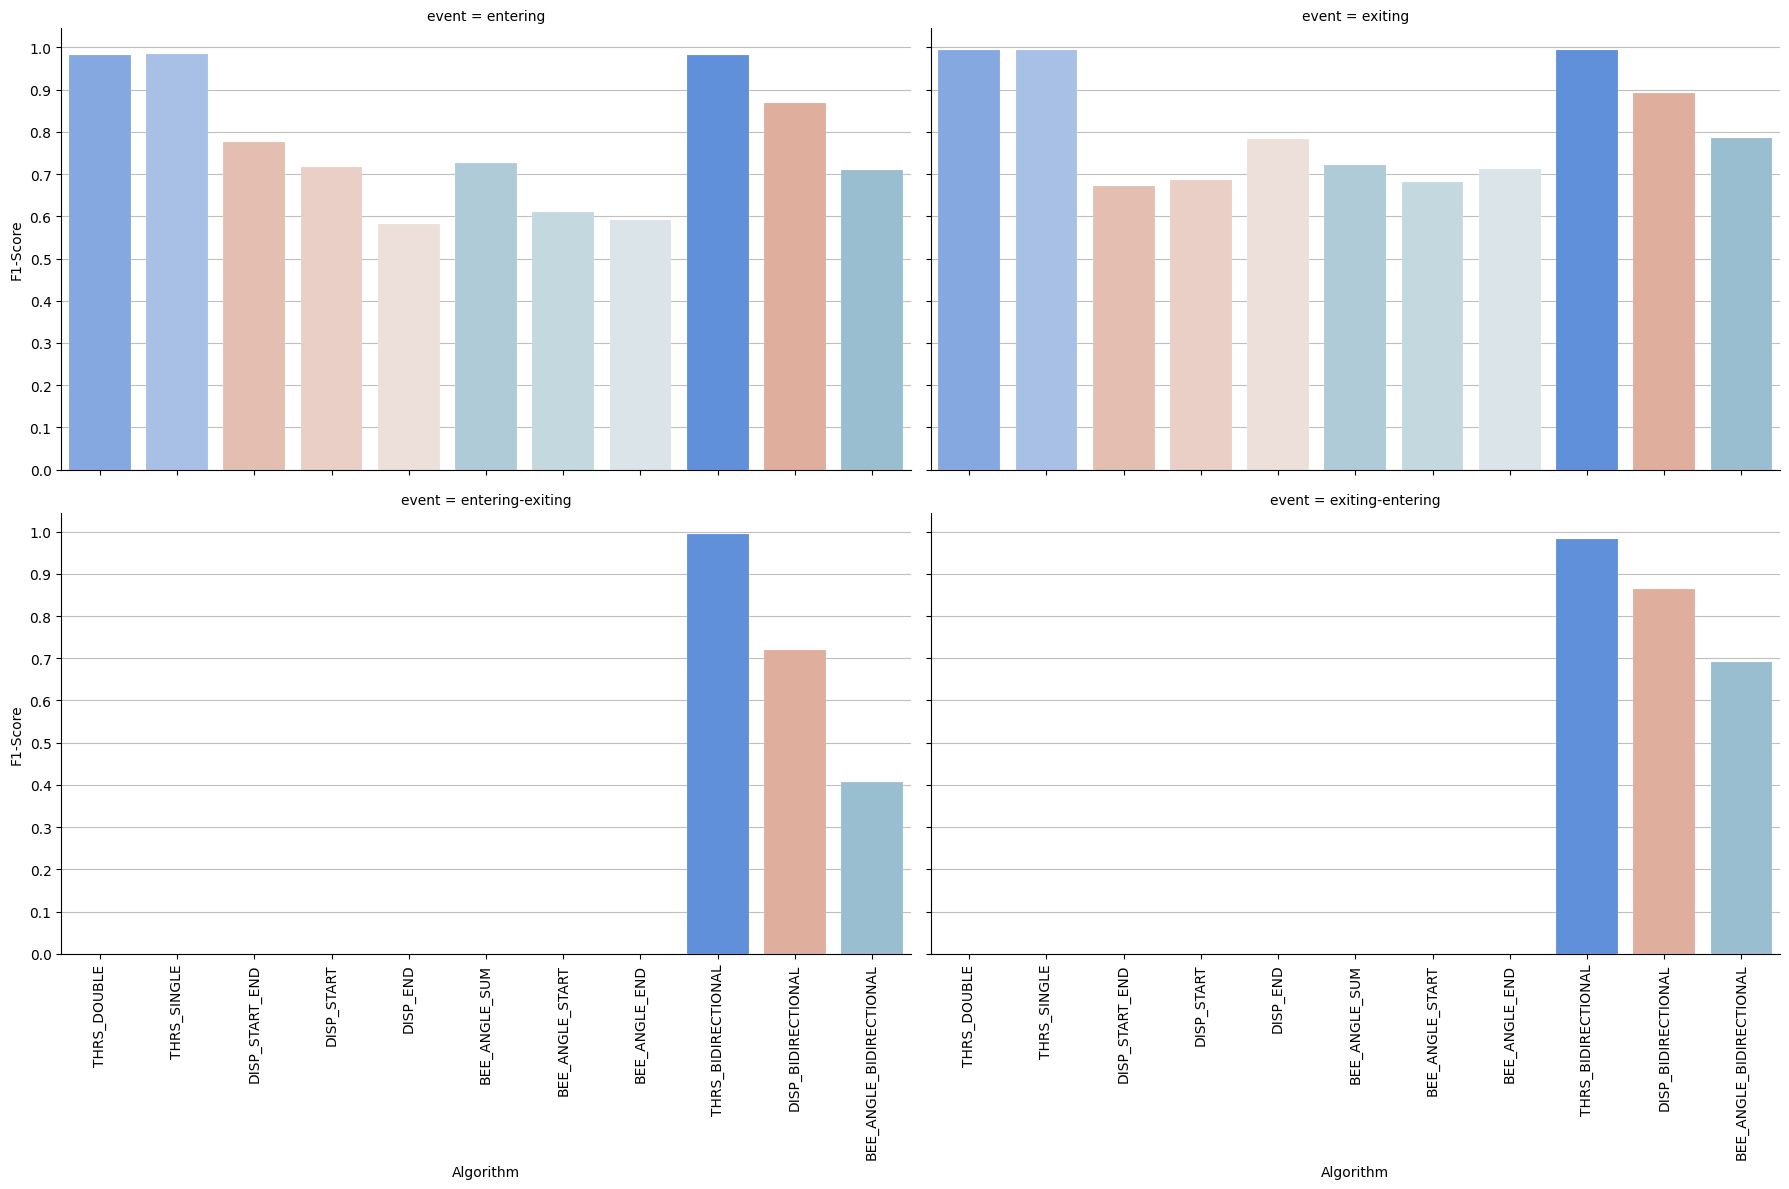

In [160]:
plot = sns.FacetGrid(df_f1_melted, col="event", hue="algorithm",height=6, aspect=1.5,col_wrap=2,palette=palette)
plot.map(sns.barplot,'algorithm','f1',order=functions.keys(),edgecolor='white',linewidth=0.1)

for ax in plot.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90) 
    ax.set_yticks(np.linspace(0,1,11))
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_axisbelow(True)

plot.set_axis_labels(x_var="Algorithm", y_var="F1-Score") 
plot.tight_layout()  

plot.savefig("f1global-1.png",bbox_inches='tight') 